## Config stuff

In [183]:
%autosave 0
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Autosave disabled


## Common code

In [184]:
from pprint import pprint

from matplotlib.text import Text
import matplotlib.pyplot as plt
import numpy as np


def plot_points(points):
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.scatter(points[:, 0], points[:, 1])
    ax = plt.gca()
    # label points
    label_points(points, "p")


def get_points(n=20):
    return np.random.random((n, 2))


def label_points(points, label, y_off=0):
    ax = plt.gca()
    for i, (x, y) in enumerate(points):
        ax.add_artist(Text(x, y + y_off, f"${label}_{{{i}}}$"))

## Convex-Hull demo

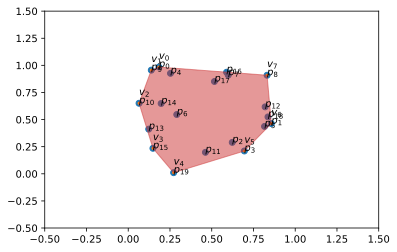

In [185]:
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon


def get_verts(points):
    hull = ConvexHull(points)
    verts = hull.vertices
    verts = np.roll(verts, -np.argmin(verts))
    # print(verts)
    return verts


def get_hull(points):
    verts = get_verts(points)
    return points[verts]


def plot_hull(points):
    verts = get_hull(points)
    plt.scatter(verts[:, 0], verts[:, 1], s=4)
    # surrounding polygon
    ax = plt.gca()
    poly = Polygon(verts, color=(0.8, 0.2, 0.2, 0.5))
    ax.add_artist(poly)
    # label vertices
    label_points(verts, "v", 0.075)


def hull_demo():
    points = get_points()
    plot_points(points)
    plot_hull(points)


hull_demo()

## Delaunay Demo

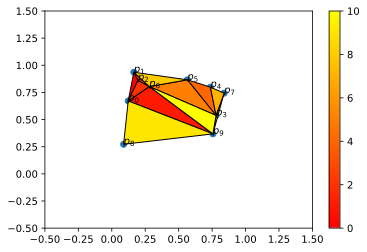

In [186]:
from scipy.spatial import Delaunay
from matplotlib.collections import PolyCollection
import matplotlib.cm as cm


def get_delaunay(points):
    return sorted(list(map(list, Delaunay(points).simplices)))


def plot_delaunay(points):
    delaunay = get_delaunay(points)
    # pprint(delaunay)
    collection = PolyCollection(
        [points[simplex] for simplex in delaunay],
        edgecolors="black",
        cmap=cm.autumn,
    )
    collection.set_array(np.arange(len(delaunay)))
    plt.gca().add_collection(collection)
    plt.colorbar(collection)


def delaunay_demo():
    points = get_points(10)
    plot_points(points)
    plot_delaunay(points)


delaunay_demo()

## Generate data sets for convex-hull

In [187]:
from typing import List, Tuple
import pickle

from torch.utils.data import TensorDataset, DataLoader
from torch import tensor
from tqdm import tqdm
import torch


def encode_verts(verts: np.array, size: int) -> np.array:
    """one-hot encode the sequence of vertices...
        position 0,1 are the beginning/ end symbols
    """
    # inspired by
    # https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
    _verts = np.concatenate(([0],verts + 2, [1]))
    one_hot = np.zeros((len(_verts), size+2))
    one_hot[np.arange(len(_verts)),_verts] = 1
    return one_hot

def get_samples_targets(n: int, size: int) -> Tuple[List[np.array], List[np.array]]:
    samples: List[np.array] = []
    targets: List[np.array] = []
    for _ in tqdm(range(n)):
        samples.append(get_points(size))
        verts = get_verts(samples[-1])
        targets.append(encode_verts(verts,size))
    return samples, targets


default_sizes = [5, 10, 20, 30]


def create_dataset(n: int, sizes=default_sizes) -> List[Tuple[np.array, np.array]]:
    """Create dataset with n samples"""
    samples: List[np.array] = []
    targets: List[np.array] = []
    for size in sizes:
        print(f"creating dataset for size {size}")
        _samples, _targets = get_samples_targets(n, size)
        samples.extend(_samples)
        targets.extend(_targets)
    return list(zip(samples, targets))


def create_and_save_dataset(n: int, filename: str, sizes=default_sizes) -> None:
    dataset = create_dataset(n, sizes)
    with open(filename, "wb") as file:
        pickle.dump(dataset, file)
    print(f"saved {n} samples to {filename}")


def get_dataloader(filename: str, seed: int = 0) -> DataLoader:
    torch.manual_seed(seed)
    with open(filename, 'rb') as file:
        return DataLoader(pickle.load(file), batch_size=1, shuffle=True)

In [190]:
def test_creation():
    filename = 'convex_hull_5kx.pickle'
    n = 5000
    create_and_save_dataset(n, filename)

loader = get_dataloader('convex_hull_5kx.pickle')
print(len(loader))

20000


 15%|█▍        | 735/5000 [00:00<00:00, 7342.65it/s]

creating dataset for size 5


 29%|██▉       | 1462/5000 [00:00<00:00, 7311.19it/s]

creating dataset for size 10


 28%|██▊       | 1408/5000 [00:00<00:00, 7040.61it/s]

creating dataset for size 20


 28%|██▊       | 1400/5000 [00:00<00:00, 7004.09it/s]

creating dataset for size 30


100%|██████████| 5000/5000 [00:00<00:00, 6999.72it/s]


saved 5000 samples to convex_hull_5kx.pickle
